In [ ]:
import re
import nltk
import mlflow
import numpy as np                                     
import pandas as pd
import matplotlib.pyplot as plt
from configuration.settings import settings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from nltk.corpus import stopwords                       
from nltk.stem.wordnet import WordNetLemmatizer       

nltk.download('stopwords')                           
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
raw_data = pd.read_csv('files/scraping_rf_v1.csv', encoding='utf-8')
raw_data['category'].value_counts()

category
Plomería                 773
Herramientas             397
Electricos               315
Ferretería               154
Aseo, Baños y Cocinas    117
Pinturas                  59
Name: count, dtype: int64

## Preprocesing

In [4]:
stop_words = set(stopwords.words('spanish')).union(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    
    words = re.split(r'\s+', text) 
    words = [word for word in words if word not in stop_words and len(word) >= 3]
    words = [lemmatizer.lemmatize(word) for word in words]  # Lematizar palabras
    return words


word_freq_by_cat = {}

raw_data['processed_name'] = (raw_data['name'].apply(lambda x: preprocess_text(x))).copy(deep=True)
raw_data.head(5)

# %%
def turn_into_strings(words):
    return ' '.join(words)

raw_data['clean_name'] = raw_data['processed_name'].apply(lambda x: turn_into_strings(x))
# raw_data.head(5)

# %%
df_co = raw_data[['category', 'clean_name']].copy()

### Building the model based on CountVectorizer and Random Forest

In [5]:
bow_vec = CountVectorizer(max_features=2000)                
data_features = bow_vec.fit_transform(df_co['clean_name'])

data_features = data_features.toarray()
data_features.shape

# %%
all_labels = df_co['category'].copy(deep=True)
all_labels = all_labels.tolist()
len(all_labels)

1815

In [6]:
# Create a dictionary mapping unique categories to numerical values
category_mapping = {category: idx for idx, category in enumerate(set(all_labels))}

# Convert categories into numerical variables
numerical_labels = [category_mapping[label] for label in all_labels]

# Display the mapping and a sample of numerical labels
print(category_mapping)
print(numerical_labels[:10])

{'Ferretería': 0, 'Electricos': 1, 'Aseo, Baños y Cocinas': 2, 'Plomería': 3, 'Pinturas': 4, 'Herramientas': 5}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Train the model

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_features, all_labels, test_size=0.3, random_state=42)

params = {
    'n_estimators': 10,
    'n_jobs': 4
}

forest = RandomForestClassifier(**params)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, all_labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7817315281403678


In [ ]:
# Set the tracking URI to the MLflow server
mlflow_uri = settings.MLFLOW_TRACKING_URI
mlflow_experiment = 'RF_Categorizer_Experiment'

mlflow.set_experiment(experiment_name=mlflow_experiment)
mlflow.set_tracking_uri(uri=mlflow_uri)

2025/09/15 18:15:28 INFO mlflow.tracking.fluent: Experiment with name 'RF_Categorizer_Experiment' does not exist. Creating a new experiment.


## Cross validation

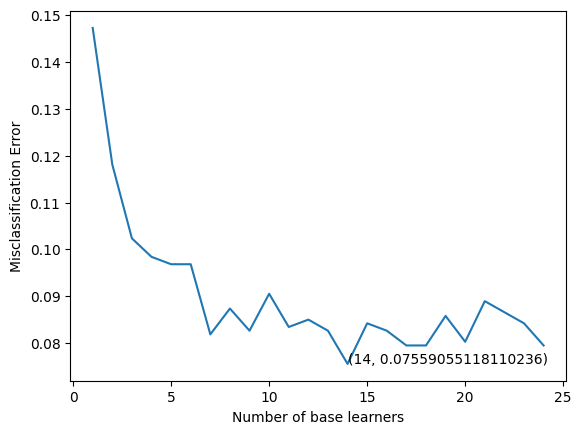

In [14]:
base_ln = [x for x in range(1, 25)]
base_ln

cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())


error = [1 - x for x in cv_scores]                                 
optimal_learners = base_ln[error.index(min(error))]                
plt.plot(base_ln, error)                                          
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

## re-train using the optimal number of learners

In [42]:
params = {
    'n_estimators': optimal_learners,
    'n_jobs': 9
}

clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9412844036697248

In [ ]:
y_pred =  clf.predict(X_test)   
report = classification_report(y_test, y_pred)
print(report)

                       precision    recall  f1-score   support

Aseo, Baños y Cocinas       1.00      0.64      0.78        42
           Electricos       0.97      0.96      0.96        94
           Ferretería       0.97      0.80      0.88        35
         Herramientas       0.84      0.98      0.91       128
             Pinturas       1.00      1.00      1.00        15
             Plomería       0.98      0.98      0.98       231

             accuracy                           0.94       545
            macro avg       0.96      0.89      0.92       545
         weighted avg       0.95      0.94      0.94       545



In [ ]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_dict.keys()

dict_keys(['Aseo, Baños y Cocinas', 'Electricos', 'Ferretería', 'Herramientas', 'Pinturas', 'Plomería', 'accuracy', 'macro avg', 'weighted avg'])

## MLFlow tracking

In [ ]:
# ['Aseo, Baños y Cocinas', 'Electricos', 'Ferretería', 'Herramientas', 'Pinturas', 'Plomería', 'accuracy', 'macro avg', 'weighted avg']
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics({
        'accuracy': report_dict['accuracy'],
        'f1_score_macro': report_dict['macro avg']['f1-score'],
        'recall_macro': report_dict['macro avg']['recall'],
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_abc': report_dict['Aseo, Baños y Cocinas']['recall'],
        'recall_electricos': report_dict['Electricos']['recall'],
        'recall_ferreteria': report_dict['Ferretería']['recall'],
        'recall_herramientas': report_dict['Herramientas']['recall'],
        'recall_pinturas': report_dict['Pinturas']['recall'],
        'recall_plomeria': report_dict['Plomería']['recall']
    })
    mlflow.sklearn.log_model(sk_model=clf, 
                             name="Random Forest Classifier CV 5",
                             registered_model_name="RF_Categorizer_Model") # Last line only if you want to register the model

2025/09/15 18:33:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RF_Categorizer_Model'.
2025/09/15 18:33:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RF_Categorizer_Model, version 1
Created version '1' of model 'RF_Categorizer_Model'.


🏃 View run unique-ox-710 at: http://127.0.0.1:5000/#/experiments/275612709309522045/runs/edb41191bde941d4b1e1f0eea9c7a698
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/275612709309522045


## Testing the MLFlow Registered model

In [55]:
test_str = ["taladro", 'foco led', 'tubo pvc', 'cinta de embalaje']

# Vectorize the new string using the already fitted vectorizer
test_features = bow_vec.transform(test_str)

# If you need it as an array
test_features = test_features.toarray()

# Predict the category using the trained model
# predicted_category = clf.predict(test_features)
model_version = 1
production_model_name = "RF_Categorizer_Model"
prod_model_uri = f"models:/{production_model_name}@champion"

loaded_model = mlflow.sklearn.load_model(prod_model_uri)
predicted_category= loaded_model.predict(test_features)
predicted_category


c:\Users\Dell\Documents\repositories\categorizer\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array(['Herramientas', 'Electricos', 'Plomería', 'Ferretería'],
      dtype='<U21')